In [ ]:
#import necxessary packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
#download data csv file
data = pd.read_csv('METABRIC_RNA_Mutation.csv')

<ipython-input-14-769808f8fd91>:2: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('METABRIC_RNA_Mutation.csv')


In [ ]:
#selected desired columns for NPI and gene expression
target = 'nottingham_prognostic_index'

X = data.iloc[:, -662:-173]  # gene expression data
y = data[target]


 #convert continuous values to binary
bins = [0, 3.4, np.inf]
labels = [0, 1]
y_binned = pd.cut(y, bins=bins, labels=labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binned, test_size=0.2, random_state=42, stratify=y_binned
)

In [ ]:
#dataset block
class GeneExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
#define resnet network layers
class ResNetBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features),
            nn.BatchNorm1d(features),
            nn.ReLU(),
            nn.Linear(features, features),
            nn.BatchNorm1d(features),)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.block(x)
        out += identity
        return self.relu(out)

In [ ]:
#pass gene expression values into layers
class ResNetClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.resblock1 = ResNetBlock(hidden_dim)
        self.resblock2 = ResNetBlock(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        return self.fc_out(x)

In [ ]:
#creates weighed sampler
def get_sampler(y_train):
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[y_train]
    return WeightedRandomSampler(sample_weights, len(sample_weights))

In [ ]:
#block to train module
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}")

In [ ]:
#evaluates trained model
def evaluate_with_metrics(model, loader, device='cuda'):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)
            y_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)



    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['NPI≤3.4', 'NPI>3.4']))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NPI≤3.4', 'NPI>3.4']).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#full pipeline
def train_resnet_with_params(X_train, y_train, X_val, y_val, hidden_dim=256, lr=1e-3, batch_size=64, num_epochs=50, device='cuda'):
    train_dataset = GeneExpressionDataset(X_train, y_train)
    val_dataset = GeneExpressionDataset(X_val, y_val)
    sampler = get_sampler(y_train.values)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ResNetClassifier(input_dim=X_train.shape[1], hidden_dim=hidden_dim)
    train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, device=device)
    return model, val_loader

In [ ]:
#tune hyperparameters
hidden_dims = [128, 256, 512]
lrs = [1e-4, 1e-3, 5e-3]
batch_sizes = [32, 64]
epochs = [30, 50]

best_acc = 0
best_params = None
best_model = None
best_loader = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for h, lr, bs, ep in product(hidden_dims, lrs, batch_sizes, epochs):
    print(f"Testing config: hidden={h}, lr={lr}, batch_size={bs}, epochs={ep}")
    model, val_loader = train_resnet_with_params(
        X_train, y_train, X_test, y_test,
        hidden_dim=h, lr=lr, batch_size=bs, num_epochs=ep,
        device=device)

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            preds = torch.argmax(model(X_batch), dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)



    acc = accuracy_score(y_true, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_params = (h, lr, bs, ep)
        best_model = model
        best_loader = val_loader







print(f"\n best accuracy: {best_acc:.4f} hidden={best_params[0]}, lr={best_params[1]}, "
      f"batch={best_params[2]}, epochs={best_params[3]}")

Testing config: hidden=128, lr=0.0001, batch_size=32, epochs=30
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Testing config: hidden=128, lr=0.0001, batch_size=32, epochs=50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Ep

Accuracy: 0.7297
Precision: 0.7799
Recall: 0.8261
F1 Score: 0.8023
ROC AUC: 0.7289

Classification Report:
              precision    recall  f1-score   support

     NPI≤3.4       0.61      0.54      0.57       128
     NPI>3.4       0.78      0.83      0.80       253

    accuracy                           0.73       381
   macro avg       0.70      0.68      0.69       381
weighted avg       0.72      0.73      0.73       381



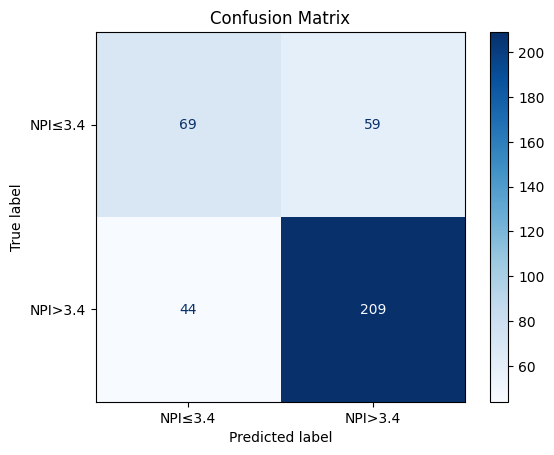

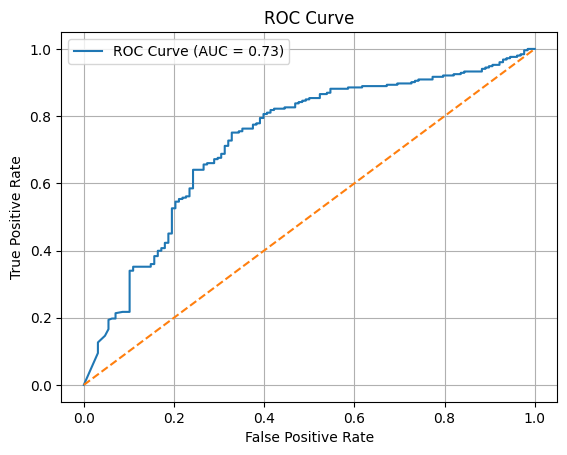

In [ ]:
#evaluate using best metrics
evaluate_with_metrics(best_model, best_loader, device=device)
